# Recreating Evolving Hockey's Expected Goals Model

## Overview
Based on a [blog](https://evolving-hockey.com/blog/a-new-expected-goals-model-for-predicting-goals-in-the-nhl/) written in 2021, I recreated the expected goals model from Evolving Hockey. I chose this model because it is one of the only remaining publically available expected goals models, and they have given a thorough description of its design, so I felt it is reasonable to recreate.

Although we both use the [NHL's RTSS data](http://www.nhl.com/scores/htmlreports/20172018/PL020672.HTM), there are some differences between their process and mine. Firstly, they code in R, while I use Python. Secondly, they used an API scraper that existed at the time (although it appears to have since been removed), while I wrote my own scraping functions. Since these functions include some preprocessing, there are differences in our data due to this. They also used a different set of seasonal data than I do. 

Overall, the majority of the data should be similar, and since there are over one million data points, differences in which shots are removed during data cleaning should have a minimal effect on the model training. Additionally, the XGBoost package is available in both Python and R, so the model used should be fundamentally the same. 

## Preprocessing
I copied their methods as much as I could in preprocessing the data. Since I am not used to reading R, I filtered the data and created features to match theirs to the best of my ability in Python. Following their lead, I removed shots that are missing location information, those which have shift errors (i.e. an impossible number of players are recorded on the ice), and blocked shots. Additionally, I removed 62 shots made by goaltenders, but I cannot imagine this has much of an impact on the model, since there are nearly seven million shots in the dataset. 

Their model separates information using boolean features, essentially using one-hot encoding. For example, they indicate the score using one of nine booleans, and the team strengths using individual booleans for each individual state. When considering how decision trees work, I understand why this makes sense, although I will test later whether this degree of boolean separation is necessary. 

## Model Evaluation
Using logloss, accuracy, and prediction calibration, I have compared the XGBoost performance to an naive Bayes model and a neural network. The XGBoost model performs better than each of these, in every category. Additionally, I compared the feature importance using sklearn's SelectKBest to the feature importance attribute of the trained XGBoost model, to determine whether the model was using the same features as predicted by other feature scoring algorithms. Lastly, the parameter results from the random parameter search are shown, to be used in future analyses. 

## Conclusions and Future Work
The model results are similar to those of Evolving Hockey. There are some slight differences in performance, which could be explained by the differences in preprocessing and different season ranges. Both mine and their model perform better than the trivial/dumb logloss baseline. 

An issue in Evolving Hockey's data preprocessing is the creation of shot type booleans (i.e. indicating whether the shot is a snap shot, slap shot, etc...). This feature is only recorded for shots that hit the net, resulting in a save or goal. However, shot type information is not recorded for shots that miss the net, which constitutes approximately 25% of the shot data. Therefore, creating a shot type boolean creates an additional implicit dummy variable (effectively leave-one-out encoding), containing information about whether the shot is on net or not. This explains why the shot type features are so prominent in the XGBoost model's feature importance, and explains the high number of shots with zero probability in the neural network model. The problem is clearly demonstrated in the distribution of predictions, divided between true misses and true shots on net. Obviously, this is problematic when using this model either to predict whether a particular shot will result in a goal, or as a tool for evaluating the value of a particular shot. Therefore, the shot type boolean will be removed in subsequent analysis, to determine its effect on model performance.

I am skeptical about whether Evolving Hockey's degree of boolean separation is necessary, so these variables will be combined and eliminated in a future analysis. I also will add and remove features, to find an optimal subset and minimize the model complexity. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import timedelta, datetime
from scipy.stats import kurtosis

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from xgboost import XGBClassifier

from models.common_sql import create_db_connection, select_table, sql_select
from models.common_plot import plot_calibration_curves
from models.common_torch import RegressionNN, CustomDataset, train_loop
from nhl_api.ref_common import game_time_to_sec


In [2]:
# Create the database connection
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432', 'password')

# Load and sort the shots data
shots_df = select_table(connection, 'shots')
shots_df.sort_values(['game_id', 'shot_id'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Load the player data as a dictionary
players_df = select_table(connection, 'players')
players_list = players_df.to_dict('records')
players = {player_x['player_id']: player_x for player_x in players_list}


# Preprocessing and Feature Selection


In [3]:
# Remove rows where the shift data contained errors
too_few_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) < 4) & shots_df.players_away.apply(lambda x: len(eval(x)) < 4)]
too_many_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) > 6) | shots_df.players_away.apply(lambda x: len(eval(x)) > 6)]
print(f'Number of shift error entries = {len(too_few_players) + len(too_many_players)} '
      f'({100 * (len(too_few_players) + len(too_many_players)) / len(shots_df):4.2f}% of all shots)')
shots_df = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) >= 4) & shots_df.players_away.apply(lambda x: len(eval(x)) >= 4) & 
                    shots_df.players_home.apply(lambda x: len(eval(x)) <= 6) & shots_df.players_away.apply(lambda x: len(eval(x)) <= 6)]

# Remove rows with nan/null shot distance or angle
null_mask = shots_df.net_distance.isna() | shots_df.net_angle.isna()
print(f'Number of shots with no distance info = {len(shots_df[null_mask])} ({100 * sum(null_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.dropna(subset=['net_distance', 'net_angle'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove rows with nan/null previous shot coordinates
null_prev_mask = shots_df.angle_change.isna() | shots_df.delta_x.isna() | shots_df.delta_y.isna()
print(f'Number of shots with no previous event location info = {len(shots_df[null_prev_mask])} '
      f'({100 * sum(null_prev_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.dropna(subset=['angle_change', 'delta_x', 'delta_y'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove blocks
block_mask = shots_df.shot_result == 'BLOCK'
blocks_df = shots_df.loc[block_mask]
blocks_df.reset_index(drop=True, inplace=True)
block_list = blocks_df.to_dict('records')
thru_prob = 1 - (sum(block_mask) / len(shots_df))  # Assumes all shots have an equal chance of being blocked
print(f'Number of shots that are blocked = {len(block_mask)} ({100 * (1 - thru_prob):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[block_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove shots made by goalies
goalie_mask = shots_df.shooter_position == 'G'
print(f'Number of shots by goalies = {sum(goalie_mask)} ({100 * sum(goalie_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[goalie_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Create shot type booleans
shots_df['wrist_shot'] = [1 if x == 'WRIST' else 0 for x in shots_df.shot_type]
shots_df['backhand_shot'] = [1 if x == 'BACKHAND' else 0 for x in shots_df.shot_type]
shots_df['slap_shot'] = [1 if x == 'SLAP' else 0 for x in shots_df.shot_type]
shots_df['tip_shot'] = [1 if x == 'TIP' else 0 for x in shots_df.shot_type]
shots_df['deflect_shot'] = [1 if x == 'DEFLECT' else 0 for x in shots_df.shot_type]
shots_df['snap_shot'] = [1 if x == 'SNAP' else 0 for x in shots_df.shot_type]
shots_df['wrap_shot'] = [1 if x == 'WRAP' else 0 for x in shots_df.shot_type]
shots_df['other_shot'] = [1 if x == 'OTHER' else 0 for x in shots_df.shot_type]

# Convert the shots to a list
shot_list = shots_df.to_dict('records')


Number of shift error entries = 735 (0.04% of all shots)
Number of shots with no distance info = 28 (0.00% of all shots)
Number of shots with no previous event location info = 799 (0.05% of all shots)
Number of shots that are blocked = 1687046 (25.19% of all shots)
Number of shots by goalies = 62 (0.00% of all shots)


In [4]:
new_feats = {'5v5': 0,
             '4v4': 0,
             '3v3': 0,
             '5v4': 0,
             '4v3': 0,
             '5v3': 0,
             '6v5': 0,
             '6v4': 0,
             '4v5': 0,
             '3v4': 0,
             '3v5': 0,
             'score_down_4': 0,
             'score_down_3': 0,
             'score_down_2': 0,
             'score_down_1': 0,
             'score_up_4': 0,
             'score_up_3': 0,
             'score_up_2': 0,
             'score_up_1': 0,
             'score_even': 0,
             'prior_shot_same': 0,
             'prior_miss_same': 0,
             'prior_block_same': 0,
             'prior_give_same': 0,
             'prior_take_same': 0,
             'prior_hit_same': 0,
             'prior_shot_opp': 0,
             'prior_miss_opp': 0,
             'prior_block_opp': 0,
             'prior_give_opp': 0,
             'prior_take_opp': 0,
             'prior_hit_opp': 0,
             'prior_faceoff': 0}


In [5]:
# Separate shots into games states
even_shots = []
pp_shots = []
pk_shots = []
en_shots = []
other_cnt = 0
for i, shot in enumerate(shot_list):
    # Extract required features
    home_shot = shot['shooter_home']
    n_home = len(eval(shot['players_home']))
    n_away = len(eval(shot['players_away']))
    en_home = shot['empty_net_home']
    en_away = shot['empty_net_away']
    
    # Remove shots
    # 6v3 shots
    if home_shot and en_home and n_home == 6 and n_away == 4:
        other_cnt += 1
        continue
    elif not home_shot and en_away and n_away == 6 and n_home == 4:
        other_cnt += 1
        continue
    # Shootout shots
    elif shot['period'] > 4 and str(shot['game_id'])[4:6] != '03':
        other_cnt += 1
        continue
        
    # Add a season column
    shot['season'] = int(str(shot['game_id'])[:4])
        
    # Convert period time to seconds (int)
    shot['period_sec'] = game_time_to_sec(shot['period_time'])
    
    # Add new feature keys
    shot.update(new_feats.copy())
    
    # Calculate prior event booleans
    if shot['last_same_team']:
        if shot['last_event_type'] == 'SHOT':
            shot['prior_shot_same'] = 1
        elif shot['last_event_type'] == 'MISS':
            shot['prior_miss_same'] = 1
        elif shot['last_event_type'] == 'BLOCK':
            shot['prior_block_same'] = 1
        elif shot['last_event_type'] == 'GIVEAWAY':
            shot['prior_give_same'] = 1
        elif shot['last_event_type'] == 'TAKEAWAY':
            shot['prior_take_same'] = 1
        elif shot['last_event_type'] == 'HIT':
            shot['prior_hit_same'] = 1
    else:
        if shot['last_event_type'] == 'SHOT':
            shot['prior_shot_opp'] = 1
        elif shot['last_event_type'] == 'MISS':
            shot['prior_miss_opp'] = 1
        elif shot['last_event_type'] == 'BLOCK':
            shot['prior_block_opp'] = 1
        elif shot['last_event_type'] == 'GIVEAWAY':
            shot['prior_give_opp'] = 1
        elif shot['last_event_type'] == 'TAKEAWAY':
            shot['prior_take_opp'] = 1
        elif shot['last_event_type'] == 'HIT':
            shot['prior_hit_opp'] = 1
    shot['prior_faceoff'] = 1 if shot['last_event_type'] == 'FACEOFF' else 0
    shot['last_same_team'] = 1 if shot['last_same_team'] else 0
    
    # Calculate lead at time of shot
    if shot['goal_lead_prior'] > 3:
        shot['score_up_4'] = 1
    elif shot['goal_lead_prior'] == 3:
        shot['score_up_3'] = 1
    elif shot['goal_lead_prior'] == 2:
        shot['score_up_2'] = 1
    elif shot['goal_lead_prior'] == 1:
        shot['score_up_1'] = 1
    elif shot['goal_lead_prior'] == 0:
        shot['score_even'] = 1
    elif shot['goal_lead_prior'] == -1:
        shot['score_down_1'] = 1
    elif shot['goal_lead_prior'] == -2:
        shot['score_down_2'] = 1
    elif shot['goal_lead_prior'] == -3:
        shot['score_down_3'] = 1
    elif shot['goal_lead_prior'] < -3:
        shot['score_down_4'] = 1
            
    # Convert target to int
    shot['goal'] = 1 if shot['goal'] else 0
        
    # Split into game states
    if en_away and home_shot:
        en_shots.append(shot)
    elif en_home and not home_shot:
        en_shots.append(shot)
    elif n_home == n_away:
        if n_home == 6 and n_away == 6:
            shot['5v5'] = 1
        elif n_home == 5 and n_away == 5:
            shot['4v4'] = 1
        elif n_home == 4 and n_away == 4:
            shot['3v3'] = 1
        if en_home or en_away:
            if home_shot and en_home:
                shot['6v5'] = 1
            elif not home_shot and en_away:
                shot['6v5'] = 1
            pp_shots.append(shot)
        else:
            even_shots.append(shot)
    elif home_shot:
        if n_home > n_away:
            if n_home == 6 and n_away == 5:
                if en_home:
                    shot['6v4'] = 1
                else:
                    shot['5v4'] = 1
            elif n_home == 6 and n_away == 4:
                shot['5v3'] = 1
            elif n_home == 5 and n_away == 4:
                shot['4v3'] = 1
            pp_shots.append(shot)
        else:
            if n_home == 5 and n_away == 6:
                shot['4v5'] = 1
            elif n_home == 4 and n_away == 6:
                shot['3v5'] = 1
            elif n_home == 4 and n_away == 5:
                shot['3v4'] = 1
            pk_shots.append(shot)
    elif not home_shot:
        if n_home < n_away:
            if n_away == 6 and n_home == 5:
                if en_away:
                    shot['6v4'] = 1
                else:
                    shot['5v4'] = 1
            elif n_away == 6 and n_home == 4:
                shot['5v3'] = 1
            elif n_away == 5 and n_home == 4:
                shot['4v3'] = 1
            pp_shots.append(shot)
        else:
            if n_away == 5 and n_home == 6:
                shot['4v5'] = 1
            elif n_away == 4 and n_home == 6:
                shot['3v5'] = 1
            elif n_away == 4 and n_home == 5:
                shot['3v4'] = 1
            pk_shots.append(shot)
print(f'Original shot list length = {len(shot_list)}')
print(f'Separated shot lists summed length = {len(even_shots) + len(pp_shots) + len(pk_shots) + len(en_shots) + other_cnt}')

game_states = [even_shots, pp_shots, pk_shots, en_shots]


Original shot list length = 1261958
Separated shot lists summed length = 1261958


In [6]:
continuous_feats = ['net_distance',  'net_angle', 'period', 'period_sec',
                    'x_coord', 'y_coord', 'last_x_coord', 'last_y_coord',
                    'dist_change', 'time_since_last']
boolean_feats = ['shooter_home', 'wrist_shot', 'backhand_shot', 'slap_shot',
                 'tip_shot', 'deflect_shot', 'snap_shot', 'wrap_shot',
                 'other_shot']
target_col = ['goal']


In [7]:
# For each game state, split the data into training and test sets

# Convert the even strength shots to a dataframe
state_ind = 0
state_list = game_states[state_ind]
data_df = pd.DataFrame(state_list, columns=list(state_list[0].keys()))
# even_df = even_df[input_cols]

# Extract the training and test data
if state_ind == 0:
    # input_cols = continuous_feats + boolean_feats + ['5v5', '4v4', '3v3'] + list(new_feats.keys())[11:] + target_col
    boolean_cols = boolean_feats + ['5v5', '4v4', '3v3'] + list(new_feats.keys())[11:]
elif state_ind == 1:
    # input_cols = continuous_feats + boolean_feats + ['5v4', '4v3', '5v3', '6v5', '6v4'] + list(new_feats.keys())[11:] + target_col
    boolean_cols = boolean_feats + ['5v4', '4v3', '5v3', '6v5', '6v4'] + list(new_feats.keys())[11:]
elif state_ind == 2:
    # input_cols = continuous_feats + boolean_feats + ['4v5', '3v4', '3v5'] + list(new_feats.keys())[11:] + target_col
    boolean_cols = boolean_feats + ['4v5', '3v4', '3v5'] + list(new_feats.keys())[11:]
elif state_ind == 3:
    # input_cols = continuous_feats + boolean_feats + list(new_feats.keys())[11:] + target_col
    boolean_cols = boolean_feats + list(new_feats.keys())[11:]
input_cols = continuous_feats + boolean_cols + target_col

# Calculate the trivial logloss for the game state
p_goal = len(data_df.loc[data_df.goal == True]) / len(data_df)
dumb_loss = -(p_goal * np.log(p_goal) + (1 - p_goal) * np.log(1 - p_goal))
print(f'{100 * p_goal:4.2f}% of {len(data_df)} even strength shots result in a goal (trivial logloss = {dumb_loss:5.4f})')

# Split the data into stratified training and test sets
train_df = data_df[data_df.season < 2017][input_cols]
X_train, y_train = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
test_df = data_df[data_df.season == 2017][input_cols]
X_test, y_test = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values


# Scale the data
n_cont_col = len(continuous_feats)
x_scaler = MinMaxScaler()
X_train_norm = x_scaler.fit_transform(X_train[:, :n_cont_col])
X_train[:, :n_cont_col] = X_train_norm
X_test_norm = x_scaler.transform(X_test[:, :n_cont_col])
X_test[:, :n_cont_col] = X_test_norm
    

5.74% of 1014131 even strength shots result in a goal (trivial logloss = 0.2199)


# Model Selection


In [8]:
# Naive Bayes model
# https://scikit-learn.org/stable/modules/naive_bayes.html#
d_nbayes = {'name': 'Naive Bayes',
            'model': GaussianNB()}

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
d_nbayes['model'].fit(X_train, y_train)
d_nbayes['train_loss'] = log_loss(y_train, d_nbayes['model'].predict_proba(X_train)[:, 1])
d_nbayes['test_pred'] = d_nbayes['model'].predict_proba(X_test)[:, 1]
d_nbayes['test_loss'] = log_loss(y_test, d_nbayes['test_pred'])
pred_classes = np.round(d_nbayes['test_pred'], 0)
d_nbayes['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the naive bayes model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_nbayes['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_nbayes['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_nbayes['test_acc']:4.2f}%")


Took 0:00:01.743663 to train the naive bayes model
Trivial logloss for this problem: 0.220
Training logloss on the NB model: 0.879
Test logloss on the NB model: 1.304
Test accuracy on the NB model: 88.49%


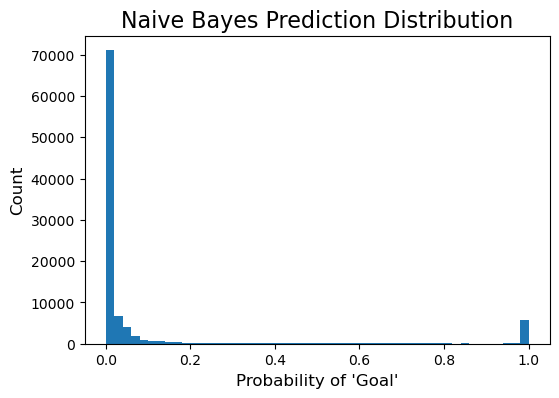

In [9]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nbayes['test_pred'], bins=50)
ax.set_title('Naive Bayes Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [10]:
# XGBoost model
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
d_xgb = {'name': 'XGBoost Classifier',
         'model': XGBClassifier(use_label_encoder=False, tree_method='hist'),
         'n_itr': 50,
         'params': {'n_estimators': [50, 100, 200, 400, 800],
                    'learning_rate': np.linspace(0.01, 0.9, 90),
                    'subsample': np.linspace(0.2, 1., 9),
                    'min_child_weight': [1, 5, 10, 20, 40],
                    'max_leaves': [2, 5, 10, 20, 40, 80],
                    'max_depth': np.arange(2, 15),
                    'lambda': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                    'gamma': [1, 2, 4, 8, 12, 16, 24]}}
cv_split = StratifiedKFold(n_splits=10)

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
param_search = RandomizedSearchCV(d_xgb['model'], d_xgb['params'], n_iter=d_xgb['n_itr'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train, y_train)
d_xgb['search_result'] = param_search
d_xgb['model'] = param_search.best_estimator_
d_xgb['train_loss'] = -param_search.best_score_

# Make predictions on the test set
d_xgb['test_pred'] = d_xgb['model'].predict_proba(X_test)[:, 1]
d_xgb['test_loss'] = log_loss(y_test, d_xgb['test_pred'])
pred_classes = np.round(d_xgb['test_pred'], 0)
d_xgb['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the xgboost model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the XGB model: {d_xgb['train_loss']:4.3f}")
print(f"Test logloss on the XGB model: {d_xgb['test_loss']:4.3f}")
print(f"Test accuracy on the XGB model: {d_xgb['test_acc']:4.2f}%")


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2465: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [-0.17325999 -0.17606204         nan -0.18098583 -0.17364919 -0.18355119
 -0.17470097 -0.1748836  -0.18004924 -0.25991887 -0.17317651 -0.18998324
 -0.17247457 -0.17101106 

Took 0:25:50.624403 to train the xgboost model
Trivial logloss for this problem: 0.220
Training logloss on the XGB model: 0.170
Test logloss on the XGB model: 0.176
Test accuracy on the XGB model: 94.29%


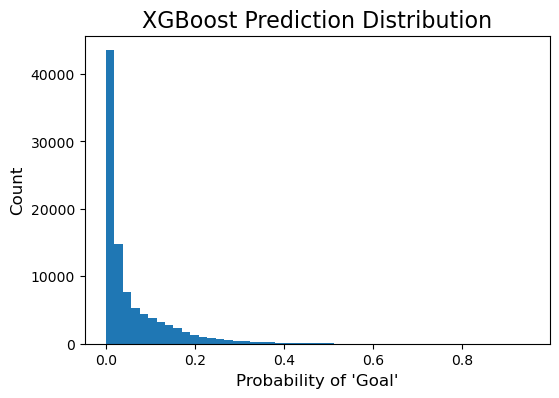

In [11]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_xgb['test_pred'], bins=50)
ax.set_title('XGBoost Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [12]:
import torch.nn as nn
from torch import optim, Tensor, sigmoid
from torch.utils.data import DataLoader


In [13]:
# Define hyperparameters
learning_rate = 1e-4
batch_size = 1024
n_epochs = 20
loss_fn = nn.BCEWithLogitsLoss()


Took 0:01:40.454377 to train the neural network
Trivial logloss for this problem: 0.220
Training logloss on the NN model: 0.190
Test logloss on the NN model: 0.195
Test accuracy on the NN model: 94.28%


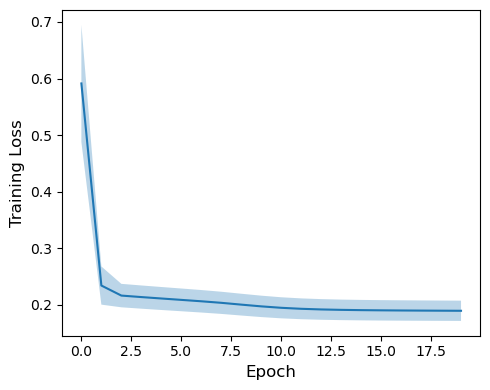

In [14]:
# Neural Network
d_nn = {'name': 'Neural Network',
        'model': RegressionNN(X_train.shape[-1], 16, 1).to('cpu').float()}

t_start = time()

# Define the training and test data loaders
train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
optimizer = optim.Adam(d_nn['model'].parameters(), lr=learning_rate)

# Train the model
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader, d_nn['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Test the model
d_nn['train_pred'] = sigmoid(d_nn['model'](Tensor(X_train.astype(float)))).detach().numpy().squeeze()
d_nn['train_loss'] = log_loss(y_train, d_nn['train_pred'], eps=1e-7)
d_nn['test_pred'] = sigmoid(d_nn['model'](Tensor(X_test.astype(float)))).detach().numpy().squeeze()
d_nn['test_loss'] = log_loss(y_test, d_nn['test_pred'], eps=1e-7)
pred_classes = np.round(d_nn['test_pred'], 0)
d_nn['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the neural network')

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
fig.tight_layout()

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NN model: {d_nn['train_loss']:4.3f}")
print(f"Test logloss on the NN model: {d_nn['test_loss']:4.3f}")
print(f"Test accuracy on the NN model: {d_nn['test_acc']:4.2f}%")


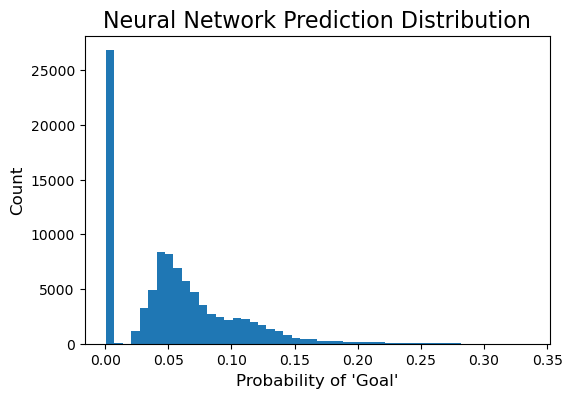

In [15]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn['test_pred'], bins=50)
ax.set_title('Neural Network Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Goal'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [16]:
# List of all model classes
model_list = [d_nbayes, d_xgb, d_nn]
n_models = len(model_list)
model_names = [model['name'] for model in model_list]


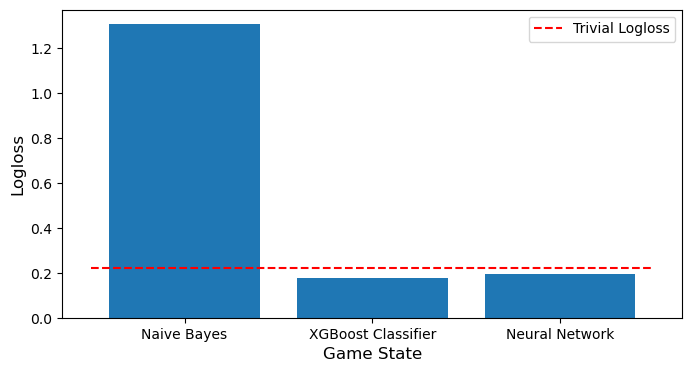

In [17]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
width = 0.8
xs = np.arange(len(model_list)) + 0.5
# train_loss = [model['train_loss'] for model in models]
test_loss = [model['test_loss'] for model in model_list]
ax.bar(xs, test_loss, width=width)
ax.plot([0, len(model_list)], [dumb_loss, dumb_loss], 'r--', label='Trivial Logloss')
ax.set_xlabel('Game State', fontsize=12)
ax.set_xticks(xs)
ax.set_xticklabels(model_names, fontsize=10)
ax.set_ylabel('Logloss', fontsize=12)
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));
ax.legend(loc=1);


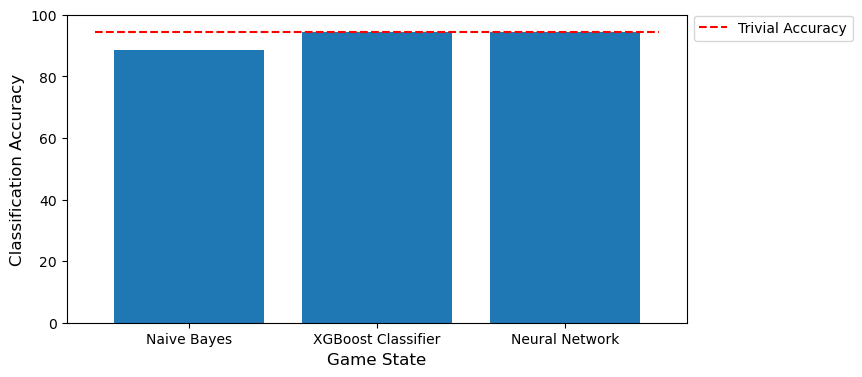

In [18]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
test_acc = [model['test_acc'] for model in model_list]
f_class = 100 * (1 - p_goal)
ax.bar(xs, test_acc, width=width)
ax.plot([0, len(model_list)], [f_class, f_class], 'r--', label='Trivial Accuracy')
ax.set_xlabel('Game State', fontsize=12)
ax.set_ylim([0, 100])
ax.set_xticks(xs)
ax.set_xticklabels(model_names, fontsize=10)
ax.set_ylabel('Classification Accuracy', fontsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:66: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


The weighted calibration errors for the models are:
Naive Bayes = 0.03244
XGBoost Classifier = 0.00190
Neural Network = 0.00206


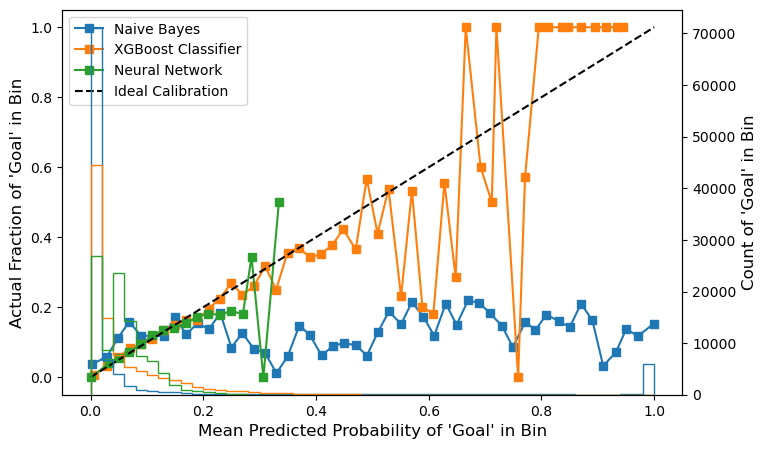

In [19]:
# Neural network calibration curves
test_preds = [model['test_pred'] for model in model_list]
test_ys = [y_test] * len(model_list)
mpl_objs = plot_calibration_curves(test_preds, test_ys, names=model_names,
                                   n_bins=50,  return_err=True, avg_curve=False,
                                   class1='Goal')
cal_errs = mpl_objs[-1]
print('The weighted calibration errors for the models are:')
for err, name in zip(cal_errs, model_names):
    print(f'{name} = {err:6.5f}')
    

# Feature Importance


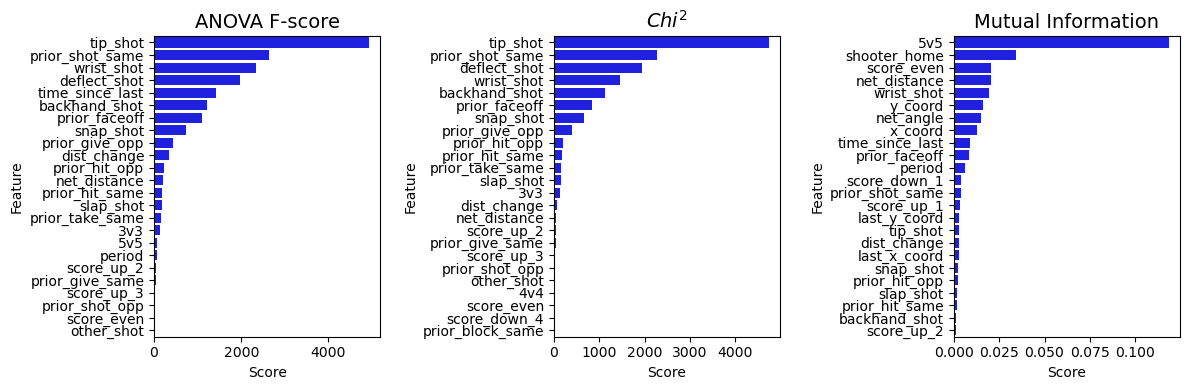

In [20]:
# Score the features using cross-correlation-based f-scoring
score_methods = [f_classif, chi2, mutual_info_classif]
score_names = ['ANOVA F-score', r'$Chi^2$', 'Mutual Information']
fig, axes = plt.subplots(1, len(score_methods), figsize=(12, 4))
for i, (method, name) in enumerate(zip(score_methods, score_names)):
    feature_eval = SelectKBest(score_func=method, k='all')
    fit = feature_eval.fit(X_train, y_train)
    best_scores = pd.DataFrame(fit.scores_)
    # feat_list = pd.DataFrame(data_df.columns[:-1])
    feat_list = pd.DataFrame(input_cols[:-1])

    select_feats = pd.concat([feat_list, best_scores], axis=1)
    select_feats.columns = ['Feature', 'Score']
    sorted_scores = select_feats.sort_values(['Score'])
    sorted_feats = sorted_scores['Feature'][:-1]
    
    sns.barplot(x="Score", y="Feature", data=sorted_scores[:-25:-1], color="b", ax=axes[i])
    axes[i].set_title(score_names[i], fontsize=14)
fig.tight_layout();


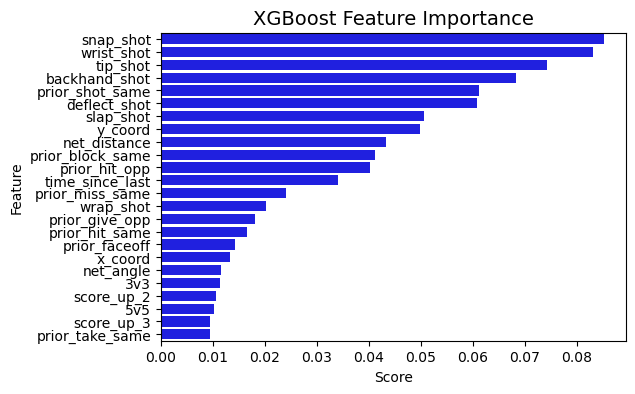

In [21]:
# Get feature importances from trained XGBoost model
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
best_scores = pd.DataFrame(d_xgb['model'].feature_importances_)
# feat_list = pd.DataFrame(data_df.columns[:-1])
feat_list = pd.DataFrame(input_cols[:-1])

select_feats = pd.concat([feat_list, best_scores], axis=1)
select_feats.columns = ['Feature', 'Score']
sorted_scores = select_feats.sort_values(['Score'])
sorted_feats = sorted_scores['Feature'][:-1]

sns.barplot(x="Score", y="Feature", data=sorted_scores[:-25:-1], color="b", ax=ax)
ax.set_title('XGBoost Feature Importance', fontsize=14);


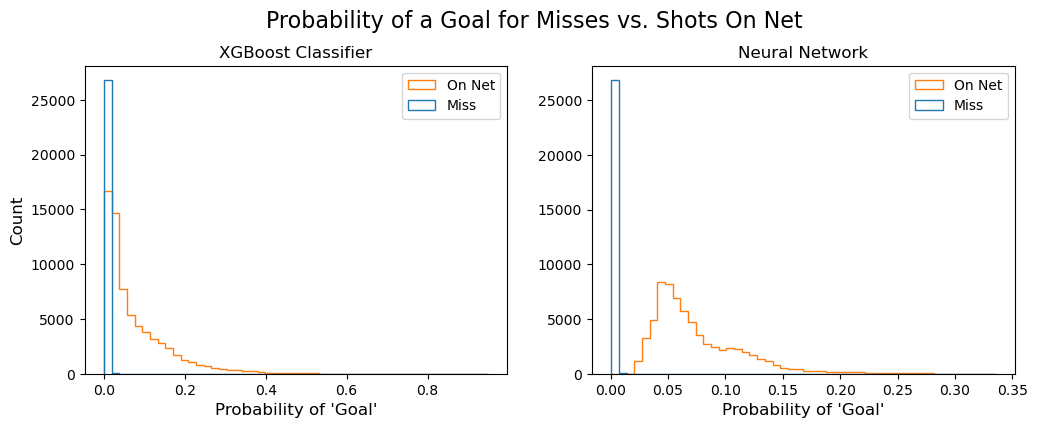

In [23]:
# Demonstrate the problem with shot type booleans
x_test_df = data_df[data_df.season == 2017]
miss_mask = x_test_df.shot_result == 'MISS'
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, d_model in enumerate([d_xgb, d_nn]):
    miss_test_pred = d_model['test_pred'][miss_mask]
    on_net_test_pred = d_model['test_pred'][~miss_mask]
    axes[i].hist([miss_test_pred, on_net_test_pred], histtype='step', bins=50, label=['Miss', 'On Net'])
    axes[i].set_xlabel("Probability of 'Goal'", fontsize=12)
    axes[i].set_title(d_model['name'], fontsize=12)
    axes[i].legend();
axes[0].set_ylabel('Count', fontsize=12)
fig.suptitle('Probability of a Goal for Misses vs. Shots On Net', fontsize=16, y=1.02);


### The problem with boolean shot types

The above plots clearly demonstrate the issue with using shot type booleans. Since this data is not recorded for missed shots, these dummy variables allow the algorithms to easily identify misses, corresponding to a zero probability that the shot results in a goal, as this information is implicitly encoded in the data. Unfortunately, this means the shot type feature cannot be used in the expected goals model.

# Hyperparameter Selection


In [24]:
# Determine hyperparameters
xgb_results = pd.DataFrame(d_xgb['search_result'].cv_results_)
xgb_results.sort_values('rank_test_score', inplace=True)
xgb_results.reset_index(drop=True, inplace=True)
# print(xgb_results.columns.tolist())
result_cols = ['param_subsample', 'param_n_estimators',
               'param_min_child_weight', 'param_max_leaves',
               'param_max_depth', 'param_learning_rate',
               'param_gamma', 'param_lambda', 'params', 'mean_test_score',
               'std_test_score', 'rank_test_score']
xgb_results = xgb_results[result_cols]
new_result_cols = ['subsample', 'n_estimators', 'min_child_weight', 'max_leaves',
                   'max_depth', 'learning_rate', 'gamma', 'lambda', 'params',
                   'mean_test_score', 'std_test_score', 'rank_test_score']
xgb_results.columns = new_result_cols
# display(xgb_results)
print(f'The average cross-validation negative Logloss is '
      f'{np.mean(xgb_results.mean_test_score):4.3f} +/- '
      f'{np.std(xgb_results.mean_test_score):4.3f}')


The average cross-validation negative Logloss is -0.177 +/- 0.014


In [25]:
display(xgb_results.head(n=20))


,subsample,n_estimators,min_child_weight,max_leaves,max_depth,learning_rate,gamma,lambda,params,mean_test_score,std_test_score,rank_test_score
0,0.6,200,5,80,4,0.28,1,0.1,"{'subsample': 0.6000000000000001, 'n_estimator...",-0.170470,0.000719,1
1,1.0,200,10,80,14,0.07,8,0.1,"{'subsample': 1.0, 'n_estimators': 200, 'min_c...",-0.170489,0.000750,2
2,0.8,800,10,40,11,0.66,8,100.0,"{'subsample': 0.8, 'n_estimators': 800, 'min_c...",-0.170560,0.000755,3
3,0.8,400,5,40,11,0.28,12,1.0,"{'subsample': 0.8, 'n_estimators': 400, 'min_c...",-0.170581,0.000727,4
4,0.6,100,40,10,13,0.43,2,1.0,"{'subsample': 0.6000000000000001, 'n_estimator...",-0.170864,0.000750,5
5,0.7,50,1,40,14,0.5,1,10.0,"{'subsample': 0.7, 'n_estimators': 50, 'min_ch...",-0.171011,0.000812,6
6,0.8,400,40,80,7,0.28,12,0.001,"{'subsample': 0.8, 'n_estimators': 400, 'min_c...",-0.171041,0.000874,7
7,0.7,50,1,20,9,0.83,4,100.0,"{'subsample': 0.7, 'n_estimators': 50, 'min_ch...",-0.171114,0.000864,8
8,0.8,100,20,10,9,0.73,2,0.1,"{'subsample': 0.8, 'n_estimators': 100, 'min_c...",-0.171138,0.000949,9
9,0.5,50,40,20,6,0.39,1,100.0,"{'subsample': 0.5, 'n_estimators': 50, 'min_ch...",-0.171160,0.000706,10
